# Task 3: Text Classification and Sentiment Analysis

## Installing and Importing Required Libraries

In [97]:
!pip install wordcloud
!pip install neattext

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from wordcloud import WordCloud
import neattext.functions as nfx
import nltk
nltk.download(['stopwords','punkt','wordnet','omw-1.4','vader_lexicon', 'averaged_perceptron_tagger'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/asudaahmed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/asudaahmed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/asudaahmed/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/asudaahmed/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/asudaahmed/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/asudaahmed/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Loading Dataset

In [180]:
data = pd.read_csv('datasets/Suicide_Detection_Dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


Since the dataset is very large to save time and resource, we'll randomly take 1000 records.

In [102]:
data = data.sample(10000)
data.head()

,Unnamed: 0,text,class
81305,122103,I feel like there’s a bad ghost inside meI’m 2...,suicide
16907,25471,Christian schools suck There are about 3 thing...,non-suicide
138276,207488,Dad bought me an escort for my 18th birthday! ...,non-suicide
60719,91067,Why is death stigmatized as a negative and liv...,suicide
77445,116278,I just need a kind voice to comfort meI just n...,suicide


## EDA

Now we have retrived the data, we will drop the first column (Unnamed: 0) we can see that there is no missing value for (text) and (class) column, let's see how many instances is there for each class.

In [105]:
data = data.drop('Unnamed: 0',axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 81305 to 68274
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   class   10000 non-null  object
dtypes: object(2)
memory usage: 234.4+ KB


Now let's see how many instances is there for each class.

In [107]:
data.describe()

,text,class
count,10000,10000
unique,10000,2
top,I feel like there’s a bad ghost inside meI’m 2...,non-suicide
freq,1,5011


class
non-suicide    5011
suicide        4989
Name: count, dtype: int64


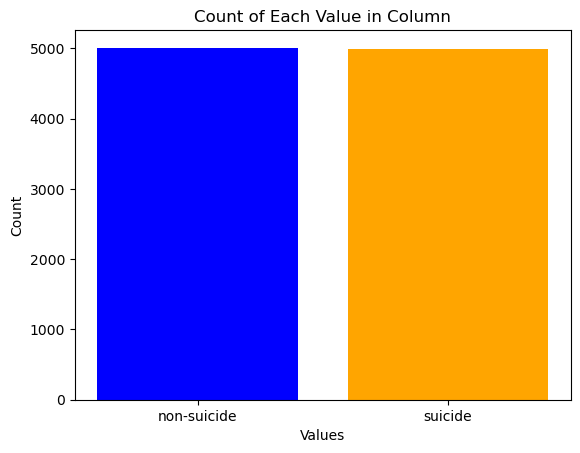

In [108]:
value_counts = data['class'].value_counts()

print(value_counts)

# Plot the histogram
plt.bar(value_counts.index, value_counts.values, color=['blue', 'orange'])
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Count of Each Value in Column')
plt.show()

The class imbalance is not significant, so there is no need to undersample or oversample the classes, now let's check the length of each text.

In [110]:
data['length'] = data['text'].str.len()
data.head(10)

,text,class,length
81305,I feel like there’s a bad ghost inside meI’m 2...,suicide,1304
16907,Christian schools suck There are about 3 thing...,non-suicide,2479
138276,Dad bought me an escort for my 18th birthday! ...,non-suicide,258
60719,Why is death stigmatized as a negative and liv...,suicide,334
77445,I just need a kind voice to comfort meI just n...,suicide,102
68993,Bro I need to vent but I can’t One of my frien...,non-suicide,311
40024,Whats the easiest way to kill myself?I'm looki...,suicide,236
223607,Dont do drugs. Technically I shouldn’t even be...,non-suicide,796
130914,I have no one to vent to. But I’m going to end...,suicide,168
115156,Hostile suicide.(spinoff of passive suicide)\n...,suicide,3236


We can see we have a good variation of text length, now let's check the word count.

In [112]:
def count_words(text):
    text_list = text.split()
    return len(text_list)
    
data['length'] = data['text'].str.len()
data['word_count'] = data['text'].apply(count_words)
data.head(10)

,text,class,length,word_count
81305,I feel like there’s a bad ghost inside meI’m 2...,suicide,1304,268
16907,Christian schools suck There are about 3 thing...,non-suicide,2479,460
138276,Dad bought me an escort for my 18th birthday! ...,non-suicide,258,50
60719,Why is death stigmatized as a negative and liv...,suicide,334,59
77445,I just need a kind voice to comfort meI just n...,suicide,102,21
68993,Bro I need to vent but I can’t One of my frien...,non-suicide,311,65
40024,Whats the easiest way to kill myself?I'm looki...,suicide,236,42
223607,Dont do drugs. Technically I shouldn’t even be...,non-suicide,796,148
130914,I have no one to vent to. But I’m going to end...,suicide,168,36
115156,Hostile suicide.(spinoff of passive suicide)\n...,suicide,3236,603


In [113]:
data.describe()

,length,word_count
count,10000.000000,10000.000000
mean,682.387300,130.458300
std,1073.369972,201.293309
min,9.000000,1.000000
25%,136.000000,25.000000
50%,310.000000,59.000000
75%,811.000000,157.000000
max,19819.000000,3610.000000


## Pre-processing

 As part of preprocessing before doing anything we will perform these text cleaning techniques:
<ol>
  <li>Converting the text to lower case</li>
  <li>Remove URLs(as these are texts from Reddit posts it's likely that they comntain URLs)</li>
  <li>Remove special characters</li>
</ol>
After that the texts are tokenized and stop words removed and finally the text is lemmatized and rejoined.

In [116]:
# Lets now create a function to apply all of our data preprocessing steps which we can then use on a corpus

from textblob import TextBlob

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(word):
    from nltk.corpus import wordnet
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(text):
    # Lowercase
    text = text.lower()
    text = re.sub(r'(?<!^)(?=[A-Z])', ' ', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove mentions and subreddit references
    text = re.sub(r'u/\S+|r/\S+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

stop_words = nltk.corpus.stopwords.words('english')

def preprocess_text(text):
    cleaned_text = clean_text(text)
    tokenized_document = nltk.tokenize.RegexpTokenizer('[a-zA-Z0-9\']+').tokenize(cleaned_text) # Tokenize
    cleaned_tokens = [word.lower() for word in tokenized_document if word.lower() not in stop_words] #Remove
    lemmatized_text = [nltk.stem.WordNetLemmatizer().lemmatize(word, get_wordnet_pos(word)) for word in cleaned_tokens] # Stemming
    return " ".join(lemmatized_text)

In [117]:
# Adjust display option
pd.set_option('display.max_colwidth', 50)


In [118]:
data['cleaned_text'] = data['text'].apply(preprocess_text)
data.head()

,text,class,length,word_count,cleaned_text
81305,I feel like there’s a bad ghost inside meI’m 2...,suicide,1304,268,feel like there bad ghost inside meim living r...
16907,Christian schools suck There are about 3 thing...,non-suicide,2479,460,christian school suck thing christian school s...
138276,Dad bought me an escort for my 18th birthday! ...,non-suicide,258,50,dad bought escort th birthday little disappoin...
60719,Why is death stigmatized as a negative and liv...,suicide,334,59,death stigmatize negative living positiveso fa...
77445,I just need a kind voice to comfort meI just n...,suicide,102,21,need kind voice comfort mei need somebody whol...


## Text Classification

In [119]:
from sklearn.model_selection import train_test_split

X = data['cleaned_text']
y = data['class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [121]:
# Train the model
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [122]:
# Evaluate the model
y_pred = model.predict(X_test_tfidf)

# Computing the accuracy and Making the Confusion Matrix
from sklearn import metrics
acc=metrics.accuracy_score(y_test,y_pred)
print('accuracy:%.2F\n\n'%(acc))
cm = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm, '\n\n')
print('----------------------------------------')
result = metrics.classification_report(y_test, y_pred)
print("Classification Report: \n",)
print(result)

accuracy:0.89


Confusion Matrix:
[[807 195]
 [ 35 963]] 


----------------------------------------
Classification Report: 

              precision    recall  f1-score   support

 non-suicide       0.96      0.81      0.88      1002
     suicide       0.83      0.96      0.89       998

    accuracy                           0.89      2000
   macro avg       0.90      0.89      0.88      2000
weighted avg       0.90      0.89      0.88      2000



In one of the examples I saw that some of the text contains mutiple repeated word in a row, I thought it might increase the efficiency of the model if I remove them. But looking at the classification report 1% improvement is not significant, and I noticed sometimes it's 15 less accurate, that depends on the sample of the records that we take in the begining as it's 1000 random sample each time.

In [123]:
def remove_duplicate_words(text):
    # Split the text into words
    words = text.split()
    # Use a set to remove duplicates while preserving order
    unique_words = list(dict.fromkeys(words))
    # Join the words back into a sentence
    return " ".join(unique_words)

data['cleaned_text2'] = data['cleaned_text'].apply(remove_duplicate_words)

In [124]:
from sklearn.model_selection import train_test_split

X2 = data['cleaned_text2']
y2 = data['class']

# Train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features
X_train_tfidf2 = tfidf.fit_transform(X_train2)
X_test_tfidf2 = tfidf.transform(X_test2)

In [125]:
# Train the model
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train_tfidf2, y_train2)

# Evaluate the model
y_pred2 = model.predict(X_test_tfidf2)

# Computing the accuracy and Making the Confusion Matrix
from sklearn import metrics
acc2=metrics.accuracy_score(y_test2,y_pred2)
print('accuracy:%.2F\n\n'%(acc2))
cm = metrics.confusion_matrix(y_test2, y_pred2)
print("Confusion Matrix:")
print(cm, '\n\n')
print('----------------------------------------')
result2 = metrics.classification_report(y_test2, y_pred2)
print("Classification Report: \n",)
print(result2)

accuracy:0.88


Confusion Matrix:
[[809 193]
 [ 42 956]] 


----------------------------------------
Classification Report: 

              precision    recall  f1-score   support

 non-suicide       0.95      0.81      0.87      1002
     suicide       0.83      0.96      0.89       998

    accuracy                           0.88      2000
   macro avg       0.89      0.88      0.88      2000
weighted avg       0.89      0.88      0.88      2000



Let's test our model with some new text that is not part of our dataset. I have used two texts:
> oh god this AI course is killing me

Now this texts shows frustration but not necessarily suicidal, as it's used to express emotion.

> oh god this AI course is killing me, i cant take it anymore i feel so down wanna jump out of the window

However this texts shows a deeper frustration with suicidal planing. 
We're expection our model to classify the first text as non-suicidal, and the second one as suicidal.

In [175]:
def predict_suicidal(text):
    processed_text = preprocess_text(text)
    print('Text: ' + processed_text)
    vectorized_text = tfidf.transform([processed_text])
    prediction = model.predict(vectorized_text)
    return "Suicidal" if prediction[0] == 'suicide' else "Not Suicidal"

# Example
new_text = 'oh god this AI course is killing me'
print('Prediction: ' + predict_suicidal(new_text))
print('\n')

new_text = 'oh god this AI course is killing me, i cant take it anymore i feel so down wanna jump out of the window'
print('Prediction: ' + predict_suicidal(new_text))

Text: oh god ai course kill
Prediction: Not Suicidal


Text: oh god ai course kill cant take anymore feel wanna jump window
Prediction: Suicidal


## Sentiment Analysis

In [127]:
# We can extract the values from the dictionary and create new columns within our dataframe
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment = SentimentIntensityAnalyzer()

data['compound'] = [sentiment.polarity_scores(text)['compound'] for text in data['cleaned_text']]
data['neg'] = [sentiment.polarity_scores(text)['neg'] for text in data['cleaned_text']]
data['neu'] = [sentiment.polarity_scores(text) ['neu'] for text in data['cleaned_text']]
data['pos'] = [sentiment.polarity_scores(text)['pos'] for text in data['cleaned_text']]

In [128]:
data = data.drop('cleaned_text2',axis=1)

In [129]:
data['polarity'] = data['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [130]:
data.head()

,text,class,length,word_count,cleaned_text,compound,neg,neu,pos,polarity
81305,I feel like there’s a bad ghost inside meI’m 2...,suicide,1304,268,feel like there bad ghost inside meim living r...,-0.9618,0.282,0.529,0.188,0.061157
16907,Christian schools suck There are about 3 thing...,non-suicide,2479,460,christian school suck thing christian school s...,-0.7707,0.185,0.673,0.142,0.010585
138276,Dad bought me an escort for my 18th birthday! ...,non-suicide,258,50,dad bought escort th birthday little disappoin...,-0.6505,0.261,0.651,0.088,-0.306250
60719,Why is death stigmatized as a negative and liv...,suicide,334,59,death stigmatize negative living positiveso fa...,-0.8402,0.342,0.498,0.161,0.300000
77445,I just need a kind voice to comfort meI just n...,suicide,102,21,need kind voice comfort mei need somebody whol...,0.8020,0.000,0.523,0.477,0.600000


In [131]:
# Assigning sentiment labels
def classify_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

data['sentiment'] = data['polarity'].apply(classify_sentiment)
data.head()

,text,class,length,word_count,cleaned_text,compound,neg,neu,pos,polarity,sentiment
81305,I feel like there’s a bad ghost inside meI’m 2...,suicide,1304,268,feel like there bad ghost inside meim living r...,-0.9618,0.282,0.529,0.188,0.061157,Positive
16907,Christian schools suck There are about 3 thing...,non-suicide,2479,460,christian school suck thing christian school s...,-0.7707,0.185,0.673,0.142,0.010585,Positive
138276,Dad bought me an escort for my 18th birthday! ...,non-suicide,258,50,dad bought escort th birthday little disappoin...,-0.6505,0.261,0.651,0.088,-0.306250,Negative
60719,Why is death stigmatized as a negative and liv...,suicide,334,59,death stigmatize negative living positiveso fa...,-0.8402,0.342,0.498,0.161,0.300000,Positive
77445,I just need a kind voice to comfort meI just n...,suicide,102,21,need kind voice comfort mei need somebody whol...,0.8020,0.000,0.523,0.477,0.600000,Positive


In [132]:
def map_sentiment_to_suicide_risk(sentiment):
    if sentiment == 'Negative':
        return 'suicide'
    else:
        return 'non-suicide'

# Map sentiments to the target labels
data['predicted_class'] = data['sentiment'].apply(map_sentiment_to_suicide_risk)

# Evaluate predictions
from sklearn.metrics import classification_report
print(classification_report(data['class'], data['predicted_class']))


              precision    recall  f1-score   support

 non-suicide       0.58      0.67      0.62      5011
     suicide       0.60      0.51      0.55      4989

    accuracy                           0.59     10000
   macro avg       0.59      0.59      0.59     10000
weighted avg       0.59      0.59      0.59     10000



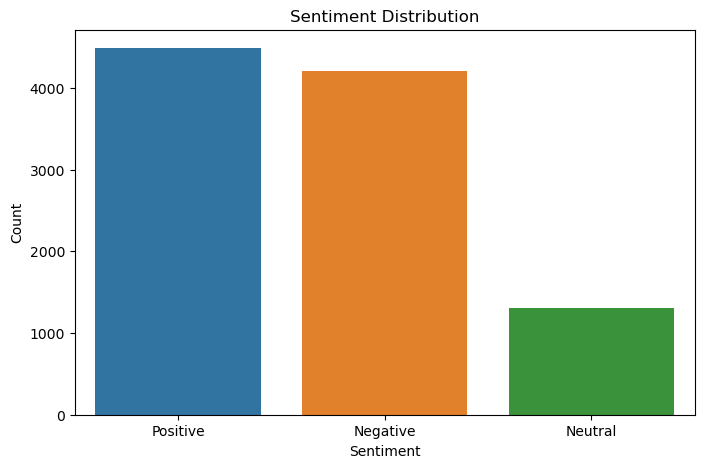

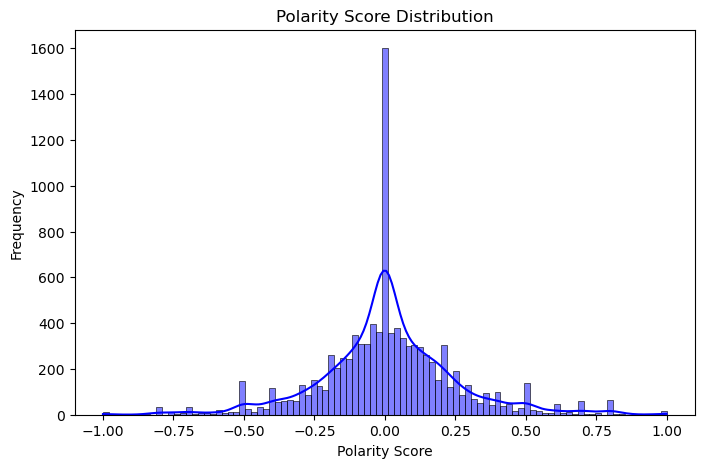

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of sentiment labels
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='sentiment', hue='sentiment')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Polarity score distribution
plt.figure(figsize=(8, 5))
sns.histplot(data['polarity'], kde=True, color='blue')
plt.title('Polarity Score Distribution')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.show()


In [134]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter text based on class
suicide_text = " ".join(data[data['class'] == 'suicide']['cleaned_text'])
non_suicide_text = " ".join(data[data['class'] == 'non-suicide']['cleaned_text'])

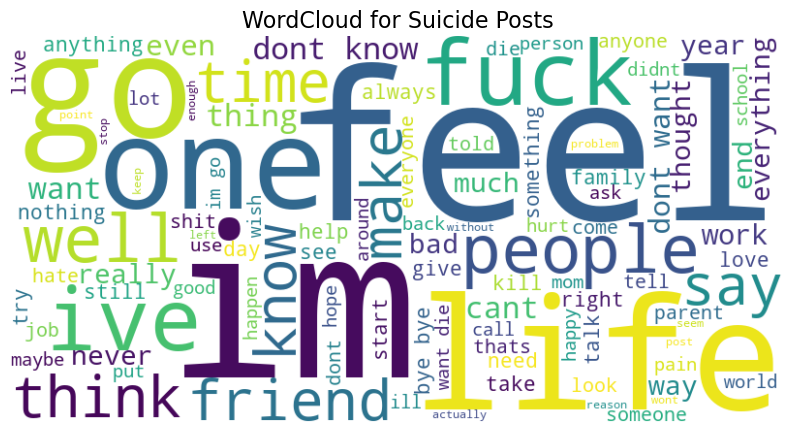

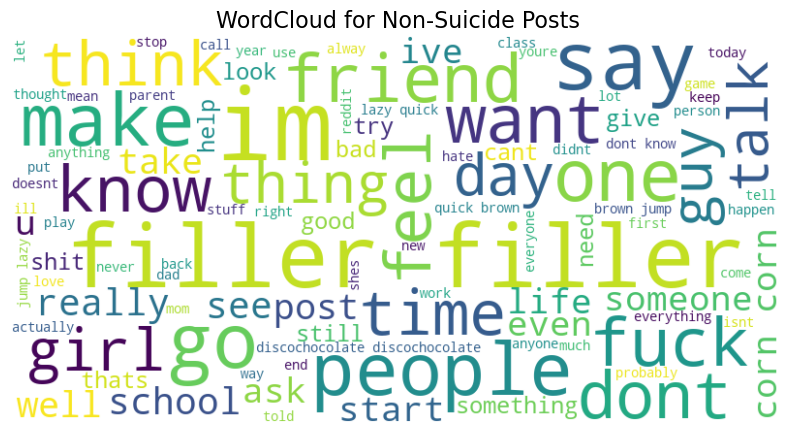

In [135]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800, height=400, 
        background_color='white', 
        colormap='viridis', 
        max_words=100
    ).generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Generate WordCloud for each class
generate_wordcloud(suicide_text, "WordCloud for Suicide Posts")
print('\n\n')
generate_wordcloud(non_suicide_text, "WordCloud for Non-Suicide Posts")
